In [7]:
from time import time

import numpy as np
import pandas as pd
import sklearn.metrics as metrics
%matplotlib inline
import matplotlib.pyplot as plt
import nltk

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import Normalizer

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [3]:
data = pd.read_csv('smsspam.csv')
x = data.drop(['class'], axis = 1)
y = data['class']

In [4]:
x_docs = x['text'].values.tolist()

In [5]:
tfidf_vect = TfidfVectorizer(stop_words='english')
x_tf_idf = tfidf_vect.fit_transform(x_docs, y)

In [8]:
norm = Normalizer()
normalized_x = norm.fit_transform(x_tf_idf, y)

In [13]:
xTrain, xTest, yTrain, yTest = train_test_split(x_tf_idf, 
                                              y,
                                              test_size=.25)

In [16]:
print xTrain.shape

(4180, 8471)


In [14]:
# Fit predict with more detailed results
mlp = MLPClassifier()
mlp.fit(xTrain, yTrain)
mlpPred = mlp.predict(xTest)

#Labelling the result
mlpPred = pd.DataFrame(data=mlpPred, columns=['class'])

#Printing test metrics
print metrics.classification_report(yTest, mlpPred)

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      1208
          1       0.99      0.84      0.91       186

avg / total       0.98      0.98      0.98      1394



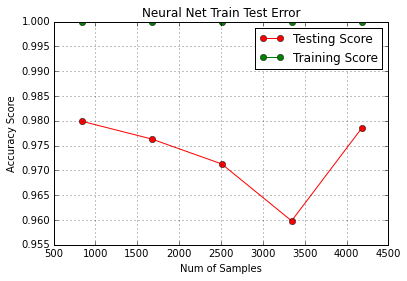

In [17]:
# TRAIN TEST ERROR MEASURER #### RUN THIS #####
sampleNum = []
trainScoreArr = []
testScoreArr = []
index = -1
bestScore = 0

for i in range (1, 6):
    xTrainRound = xTrain
    yTrainRound = yTrain
    if i < 5:
        xTrainRound, throwaway1, yTrainRound, throwaway2 = train_test_split(xTrain, yTrain, test_size=i/5.0)
    
    
    mlp = MLPClassifier()
    mlp.fit(xTrainRound, yTrainRound)
    
    trainPredRes = mlp.predict(xTrainRound)
    trainPredRes = pd.DataFrame(data=trainPredRes, columns=['hand'])
    trainAcc = accuracy_score(yTrainRound, trainPredRes)
    
    testPredRes = mlp.predict(xTest)
    testPredRes = pd.DataFrame(data=testPredRes, columns=['hand'])
    testAcc = accuracy_score(yTest, testPredRes)
    
    if testAcc > bestScore:
        index = i
        bestScore = testAcc
    trainScoreArr.append(trainAcc)
    testScoreArr.append(testAcc)
    sampleNum.append(4180 * i / 5.0)
    

plt.figure()
plt.title("Neural Net Train Test Error")
plt.xlabel("Num of Samples")
plt.ylabel("Accuracy Score")
# plt.ylim(*(0.4, 0.8))

plt.grid()

plt.plot(sampleNum, testScoreArr, 'o-', color="r", label = "Testing Score")
plt.plot(sampleNum, trainScoreArr, 'o-', color="g", label = "Training Score")
plt.legend(loc="best")

In [15]:
kmeans = KMeans(n_clusters=2)

In [16]:
kmeans.fit(normalized_x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [17]:
cluster_pred = kmeans.predict(x_tf_idf)

In [18]:
cluster_pred = kmeans.predict(x_tf_idf)
#Labelling the result
cluster_pred = pd.DataFrame(data=cluster_pred, columns=['class'])

#Printing test metrics
print metrics.classification_report(y, cluster_pred)

             precision    recall  f1-score   support

          0       0.86      0.96      0.91      4827
          1       0.01      0.00      0.00       747

avg / total       0.75      0.83      0.79      5574



In [19]:
def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_)))
    print confusion_matrix(labels, estimator.labels_)

In [20]:
print x_tf_idf.shape

(5574, 8471)


In [21]:
n_samples, n_features = x_tf_idf.shape
n_classes = len(np.unique(y))
labels = y
sample_size = 5574 * 0.16

In [22]:
bench_k_means(KMeans(init='k-means++', n_clusters=n_classes, n_init = 10, max_iter = 10000),
              name="k-means++", data=normalized_x)
bench_k_means(KMeans(init='random', n_clusters=n_classes, n_init=10, max_iter = 10000),
              name="random", data=normalized_x)

k-means++	4.90s	5477	0.011	0.029	0.016	-0.046	0.011
[[ 198 4629]
 [   1  746]]
random   	4.65s	5477	0.011	0.029	0.016	-0.046	0.011
[[4629  198]
 [ 746    1]]


In [49]:
pca = TruncatedSVD(n_components=2).fit(x_tf_idf)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_classes, n_init=1, max_iter = 10000),
              name="PCA-based",
              data=normalized_x)
print(82 * '_')

PCA-based	0.43s	5485	0.011	0.032	0.016	-0.040	0.010
[[4669  158]
 [ 747    0]]
__________________________________________________________________________________


In [52]:
def bench_em(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_)))
    print confusion_matrix(labels, estimator.labels_)

In [26]:
dense_x = x_tf_idf.todense()
em = GaussianMixture(n_components = n_classes).fit(dense_x)

In [28]:
emPred = em.predict(dense_x)

In [29]:
print metrics.homogeneity_score(y, emPred)
print metrics.completeness_score(y, emPred)
print metrics.v_measure_score(y, emPred)
print metrics.adjusted_rand_score(y, emPred)
print metrics.adjusted_mutual_info_score(y, emPred)

0.014914735474450887
0.03171651800771431
0.02028868799062583
-0.055611932182420803
0.01468922800801919
